In [1]:
import sys
import os
current_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import torch as tr 
import torch.nn as nn 
import torch.nn.functional as F
from einops import rearrange

from src.dataset import SeqDataset
# from src.dd_model.unet import Unet
from src.layers.simpleunet import SimpleUNet


# Dataset

Se extiende la clase SeqDataset (pendiente- quitar componentes innecesarias).
Ahora proporciona:
- contact_oh (2xLxL),
- outer (16xLxL),

 para ser utilizados como target y condition.

In [3]:
data_path = '../data/ArchiveII.csv'
seq_ds = SeqDataset(data_path)
print(len(seq_ds), seq_ds[0].keys()) 
seq_ds[0]["embedding"].shape

3864 dict_keys(['embedding', 'contact', 'contact_oh', 'outer', 'length', 'canonical_mask', 'id', 'sequence', 'interaction_prior'])


torch.Size([4, 112])

In [4]:
# ejemplo outer prod
vec = tr.tensor([1, 2, 3, 4])
expand = vec[:, None] * vec[None, :]  # Outer product
# Resultado:
print(vec.shape)
print(expand.shape)
print(expand)

torch.Size([4])
torch.Size([4, 4])
tensor([[ 1,  2,  3,  4],
        [ 2,  4,  6,  8],
        [ 3,  6,  9, 12],
        [ 4,  8, 12, 16]])


In [5]:
print(seq_ds[0]["contact"].shape)
print(seq_ds[0]["contact_oh"].shape) 



torch.Size([112, 112])
torch.Size([2, 112, 112])


In [6]:
print(seq_ds[0]["embedding"].shape)
print(seq_ds[0]["contact_oh"].shape)
print(seq_ds[0]["outer"].shape)

torch.Size([4, 112])
torch.Size([2, 112, 112])
torch.Size([16, 112, 112])


In [7]:
print(f"seq_ds[0]['contact_oh']:    {seq_ds[0]['contact_oh'].shape}")
print(f"seq_ds[0]['contact_oh'][0]: {seq_ds[0]['contact_oh'][0].shape}")
print(f"seq_ds[0]['outer']:         {seq_ds[0]['outer'].shape}")
print(f"seq_ds[0]['outer'][0]:      {seq_ds[0]['outer'][0].shape}")

seq_ds[0]['contact_oh']:    torch.Size([2, 112, 112])
seq_ds[0]['contact_oh'][0]: torch.Size([112, 112])


seq_ds[0]['outer']:         torch.Size([16, 112, 112])
seq_ds[0]['outer'][0]:      torch.Size([112, 112])


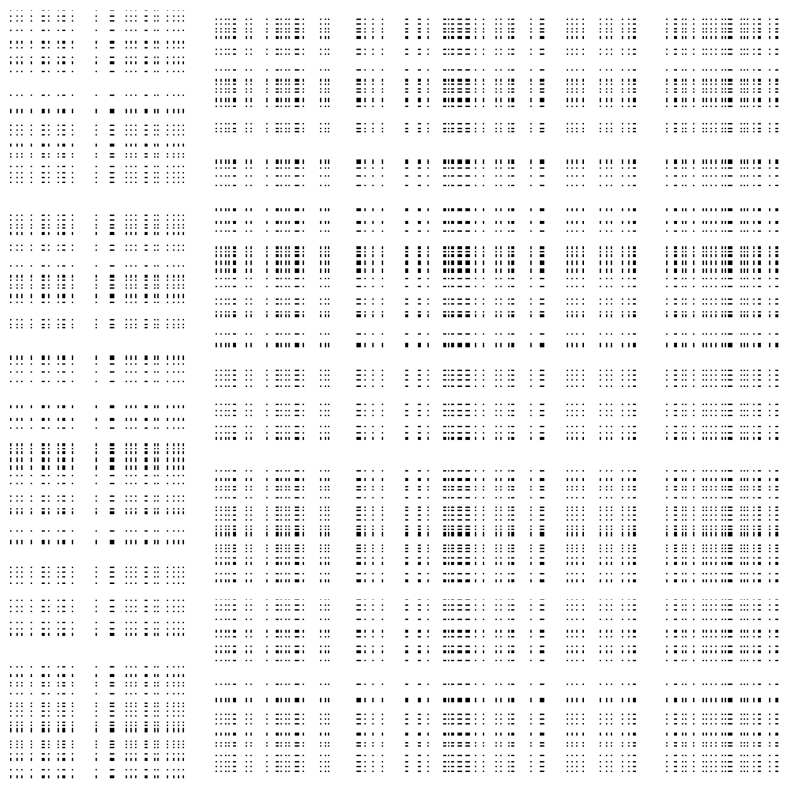

In [8]:
fig, axes = plt.subplots(4,4, figsize=(8,8)) 
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(seq_ds[1]["outer"][(i*4 + j)-1].cpu(), cmap='Greys')
     #   axes[i,j].set_title(f"i:{i}, j:{j}")
        axes[i,j].axis('off')
plt.tight_layout()
plt.show()

# Test the model

I build the concatenated tensor : structure(OH) + CONDITIONING, and unsqueeze in the dim 0 to make the batch dimension.

After that,  the `SimpleUNet` model is instantiated, and a forward pass is performed.

In [9]:
cm_oh = seq_ds[0]["contact_oh"]
outer = seq_ds[0]["outer"]
concat = tr.cat([cm_oh, outer], dim=0)
print(concat.shape)
concat = concat.unsqueeze(0)  # Add batch dimension
print(concat.shape)

torch.Size([18, 112, 112])
torch.Size([1, 18, 112, 112])


torch.Size([1, 8])
torch.Size([1, 8])


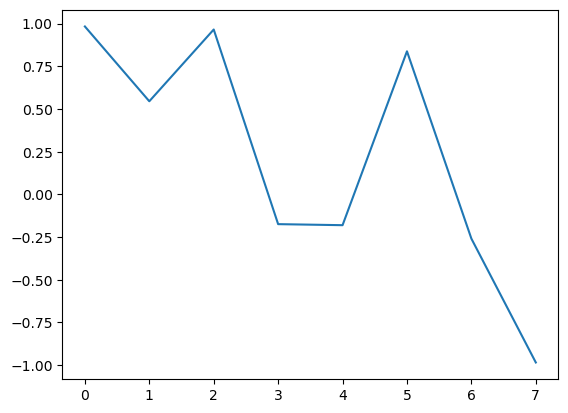

In [10]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, num_steps, rescale_steps=40, flip_sin_to_cos=False):
        super().__init__()
        self.dim = dim
        self.num_steps = float(num_steps)
        self.rescale_steps = float(rescale_steps)
        self.flip_sin_to_cos = flip_sin_to_cos

    def forward(self, x):
        x = x / self.num_steps * self.rescale_steps
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10) / (half_dim - 1)
        emb = tr.exp(tr.arange(half_dim, device=device) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        emb = tr.cat((emb.sin(), emb.cos()), dim=-1)
        if self.flip_sin_to_cos:
            emb = tr.cat([emb[:, half_dim:], emb[:, :half_dim]], dim=-1)
        return emb
    

batch_size = 1
num_steps=8
time = tr.randint(0, 1000, (batch_size,))  # Random time steps
time_emb = SinusoidalPosEmb(num_steps, 100)(time)
print(time_emb.shape)  # Should be [batch_size, num_steps]  
print(time_emb.shape)
plt.plot([i for i in range(time_emb.shape[1])], time_emb[0])

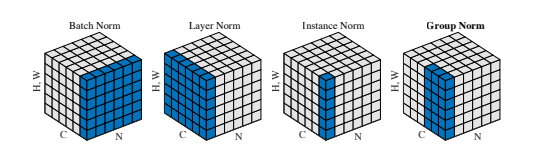

In [11]:
model = SimpleUNet(in_channels=18, out_channels=2, base_dim=64)
out = model(concat, time)
print(f"time: {time}")
print(f"out.shape: {out.shape}")

time: tensor([240])
out.shape: torch.Size([1, 2, 112, 112])


In [12]:
example = tr.zeros(2,2,3,4) 

print(example)


tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]])


In [13]:
#time_condition = self.mlp(time_emb)[:, :, None, None]
t_emb = tr.Tensor(
    [[0.1, 0.2],
     [0.4, 0.5]]
)
print(t_emb.shape)
t_emb[:, :, None, None].shape

torch.Size([2, 2])


torch.Size([2, 2, 1, 1])

In [14]:
example + t_emb[:, :, None, None]

tensor([[[[0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000, 0.1000]],

         [[0.2000, 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000, 0.2000]]],


        [[[0.4000, 0.4000, 0.4000, 0.4000],
          [0.4000, 0.4000, 0.4000, 0.4000],
          [0.4000, 0.4000, 0.4000, 0.4000]],

         [[0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000]]]])

In [15]:
def linear_betas(timesteps):
    betas = tr.linspace(0.0001, 0.01, timesteps, dtype=tr.float32)
    return betas

def cosine_betas(timesteps, s=0.008):
    """
    Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    Better for discrete data to prevent abrupt noise injection.
    """
    steps = timesteps + 1
    x = tr.linspace(0, timesteps, steps, dtype=tr.float32)
    alphas_cumprod = tr.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return tr.clip(betas, 0, 0.999)

def get_schedule(timesteps, get_betas, log=False):
    # beta = 1 - alpha
    betas = get_betas(timesteps)
    alphas = 1 - betas
    alphas_bar = tr.cumprod(alphas, dim=0)
    one_minus_alphas_bar = 1 - alphas_bar
    if log:
        return tr.log(betas), tr.log(alphas) , tr.log(alphas_bar), tr.log(one_minus_alphas_bar)
    else:
        return betas, alphas, alphas_bar, one_minus_alphas_bar

T = 2000 # El número de pasos de difusión
betas, alphas, alphas_bar, one_minus_alphas_bar = get_schedule(T, linear_betas)

In [16]:
def extract(a, t, x_shape):
    """ Extrae los valores correspondientes de 'a' en los índices 't' y los reformatea para que coincidan con 'x_shape' """
    batch_size = t.shape[0]
    out = a.gather(-1, t)  # Extrae los valores en los índices 't'
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))  # Reformatea para que coincida con 'x_shape'

$q(x_t | x_0) = \bar{\alpha}_t \cdot \text{one\_hot}(x_0) + (1 - \bar{\alpha}_t) / K$

 $q(x_t | x_{t-1}) = \alpha_t \cdot \text{one\_hot}(x_{t-1}) + \frac{1 - \alpha_t}{K}$

In [17]:
# ref https://github.com/ehoogeboom/multinomial_diffusion/blob/main/diffusion_utils/diffusion_multinomial.py
# ref 2 https://github.com/lucidrains/denoising-diffusion-pytorch/blob/5989f4c77eafcdc6be0fb4739f0f277a6dd7f7d8/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py

class DiffusionModel(nn.Module):
    def __init__(self, num_classes,  time_steps, model, **kwargs):
        super().__init__() 
        self.diffuser = model(**kwargs)
        self.num_classes = num_classes
        self.time_steps = time_steps
        
        # about buffers: https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723
        # 2. Registramos los buffers con shape (T, 1, 1, 1)
        # Esto permite multiplicar directo por imágenes [B, C, H, W] sin hacer .view() en cada forward
        betas, alphas, alphas_bar, one_minus_alphas_bar = get_schedule(time_steps, cosine_betas)
        self.register_buffer("one_minus_alphas", one_minus_alphas_bar)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_bar", alphas_bar)
        self.register_buffer("one_minus_alphas_bar", one_minus_alphas_bar)
        
        # buffer de Lt para nll estocastico


        
    def q_pred(self, x0, t):
        """ Dada una imagen x0 y un tiempo t, obtiene q(xt|x0)
        x0: tensor de shape (batch_size, channels, height, width) con valores enteros entre 0 y num_classes-1
        t: tensor de shape (batch_size,) con valores enteros entre 0 y time_steps-1
        return: tensor de shape (batch_size, height, width) con valores enteros entre 0 y num_classes-1            
        """
    
        # le agrego al mapa de contactos la clase 0/1        
        alphas_bar = extract(self.alphas_bar, t, x0.shape)
        one_minus_alphas_bar = extract(self.one_minus_alphas_bar, t, x0.shape)
        
        # La distribución qt es una mezcla entre la distribución one-hot y la distribución uniforme
        # q(xt|x0) 
        probs = alphas_bar * x0 + one_minus_alphas_bar / self.num_classes
        return probs
    
    def q_step(self, xt_1, t):
        """ Dada una imagen xt_1 y un tiempo t, obtiene q(xt|xt_1)
        xt_1: tensor de shape (batch_size, height, width) con valores enteros entre 0 y num_classes-1
        t: tensor de shape (batch_size,) con valores enteros entre 0 y time_steps-1
        return: tensor de shape (batch_size, height, width) con valores enteros entre 0 y num_classes-1            
        """
    
        # le agrego al mapa de contactos la clase 0/1
       # Convertir indices a One-Hot y mover canales al lugar 1: [B, L, L, 2] -> [B, 2, L, L]
        xt_1_one_hot = F.one_hot(xt_1, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # el vector alphas_t tiene que tener shape (batch_size, 1, 1, 1) para que la multiplicacion de matrices funcione
        alphas_t = extract(self.alphas, t, xt_1_one_hot.shape)
        one_minus_alpha_t = extract(self.one_minus_alphas, t, xt_1_one_hot.shape)
        # La distribución qt es una mezcla entre la distribución one-hot y la distribución uniforme
        qxt = alphas_t * xt_1_one_hot + one_minus_alpha_t / self.num_classes
        return qxt

    def q_posterior(self, x0, xt, t):
        """ Dada una imagen xt, una x0 y un tiempo t, calcula la distribución q(xt-1|xt,x0)
        xt: tensor de shape (batch_size, height, width) con valores enteros entre 0 y num_classes-1
        x0: tensor de shape (batch_size, height, width) con valores enteros entre 0 y num_classes-1
        t: tensor de shape (batch_size,) con valores enteros entre 0 y time_steps-1
        return: tensor de shape (batch_size, height, width, num_classes) con las probabilidades de cada clase en cada pixel           
        """
        
        # Si x0 son indices (hard reconstruction), lo pasamos a OH. Si son probs, lo dejamos.
        if x0.dtype == tr.long or x0.dtype == tr.int:
             x0_vec = F.one_hot(x0, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        else:
             x0_vec = x0 # Asumimos que ya son probabilidades [B, 2, L, L]
        
        # q(xt-1 | xt, x0) = q(xt | xt-1, x0) * q(xt-1 | x0) / q(xt | x0)
        # where q(xt | xt-1, x0) = q(xt | xt-1).
        
        # le agrego al mapa de contactos la clase 0/1
        xt_vec = F.one_hot(xt, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
                
        t_1 = tr.clamp(t-1, min=0) # t-1, pero no menor a 0
        qxt_1_given_x0 = self.q_pred(x0_vec, t_1)  # q(xt-1|x0)
        
        qxt_1_given_x0 = tr.where(t.view(-1, 1, 1, 1) == 0,
                                  x0_vec,
                                  qxt_1_given_x0
                                  )  # Si t=0, entonces xt-1 = x0
        # q(xt|xt-1)
        # NOTA MATEMÁTICA: En Hoogeboom q(xt|xt-1) es simétrico. 
        # Podemos reusar la logica de q_step pasando xt como "base"
        qxt_given_xt_1 = self.q_step(xt, t)
        posterior = qxt_1_given_x0 * qxt_given_xt_1  # p(xt-1|xt,x0)        
        # Normalizo para que sea una distribución de probabilidad
        # sobre la dimensión de canales (dim 1)
        posterior = posterior / (posterior.sum(dim=1, keepdim=True) + 1e-8)
        return posterior     
        
    def predict_start(self, xt, t, condition, return_logits=False):
        """
        Predice x0 (probabilidades) a partir de xt.
        Equivalente a p(x0 | xt).
        """
        # 1. Preparar entrada: Indices -> OneHot y Concatenación -> 2 + 16 = 18 canales
        xt_oh = F.one_hot(xt, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        unet_input = tr.cat([xt_oh, condition], dim=1)

        # 2. Forward del modelo (Denoise function)
        out = self.diffuser(unet_input, t)

        # 3. Assertions de seguridad (Tal como en tu ejemplo)
        assert out.size(0) == xt.size(0)
        assert out.size(1) == self.num_classes
        assert out.size()[2:] == xt.size()[1:]

        # Caso especial: Para entrenamiento necesitamos logits crudos para CrossEntropy
        if return_logits:
            return out

        # 4. Retornar Probabilidades (Softmax)
        pred = F.softmax(out, dim=1)
        return pred
    
    def pred_p_xt_1_from_xt(self, xt, t, condition):
        # Obtenemos p(x0 | xt)
        pred = self.predict_start(xt, t, condition) 
        # Calculamos posterior q(xt-1 | xt, x0_pred)
        # Pasamos las probabilidades directas (Soft Decision) en vez de argmax (Hard Decision)
        # para mejor información, aunque argmax funciona también.
        return self.q_posterior(pred.argmax(dim=1), xt, t)
    
    def sample_from_logits(self, probs):
        
        # Debo acomodar las dimensiones para que multinomial funcione
        batch_size, num_classes, height, width = probs.shape
        probs = probs.permute(0, 2, 3, 1)  # [B, H, W, C]
        probs_flat = probs.view(-1, num_classes)
        
        # Tomo una muestra de la distribución logits
        sampled = tr.multinomial(probs_flat, num_samples=1).squeeze(-1)
        # Debo volver a darle la forma original a sampled
        sampled = sampled.view(batch_size, height, width)
        return sampled    
    
    
    def q_sample(self, x0, t):
        # x0 viene como [B, 2, L, L] (One Hot)
        qxt_x0 = self.q_pred(x0, t)  # Obtengo la distribución qt
        sample = self.sample_from_logits(qxt_x0)  # Muestreo de la distribución qt
        return sample
    
    
    @tr.no_grad()
    def p_sample(self, xt, t, condition):
        # Obtenemos probabilidades de la posterior [B, 2, L, L]
        posterior_probs = self.pred_p_xt_1_from_xt(xt, t, condition) 
        # Muestreamos de la distribución predicha
        out = self.sample_from_logits(posterior_probs)
        return out

    @tr.no_grad()
    def p_sample_loop(self, shape, condition):
        """ Muestrea una imagen desde ruido puro """
        batch_size = shape[0]
        device = self.alphas.device
        # Empezamos desde ruido puro (uniforme)
        xt = tr.randint(0, self.num_classes, shape, device=device).long() 
        
        for t in reversed(range(1, self.time_steps)):
            t_batch = tr.full((batch_size,), t, device=device, dtype=tr.long)
            xt = self.p_sample(xt, t_batch, condition)
        return xt
    
    @tr.no_grad()
    def _sample(self, condition):
        shape = (condition.shape[0], condition.shape[2], condition.shape[3]) # batch_size, height, width, dim=1 -> channel
        samples = self.p_sample_loop(shape, condition)
        return samples
    
    def compute_vlb(self, x0_oh, xt, t, condition):
            """
            Calcula la Variational Lower Bound (KL Divergence) para el paso t.
            KL( q(x_{t-1}|x_t, x_0) || p(x_{t-1}|x_t, \hat{x}_0) )
            """
            # 1. Calcular la Posterior Real (Ground Truth)
            # Usamos x0_oh (one-hot real) y xt (indices actuales)
            true_posterior = self.q_posterior(x0_oh, xt, t) # [B, 2, L, L]
            
            # 2. Calcular la Posterior Predicha (Network Estimate)
            # Obtenemos la predicción de x0 (probabilidades) desde la red
            # Nota: return_logits=False porque q_posterior espera probabilidades en el arg 1
            pred_x0_probs = self.predict_start(xt, t, condition, return_logits=False)
            pred_posterior = self.q_posterior(pred_x0_probs, xt, t) # [B, 2, L, L]
            
            # 3. Calcular KL Divergence: Sum(P * log(P / Q))
            # Clamp para estabilidad numérica (evitar log(0))
            eps = 1e-8
            true_posterior = tr.clamp(true_posterior, min=eps, max=1.0)
            pred_posterior = tr.clamp(pred_posterior, min=eps, max=1.0)
            
            # Calculamos KL por píxel y por canal
            kl = true_posterior * (tr.log(true_posterior) - tr.log(pred_posterior))
            
            # Sumamos sobre las clases (dim 1) -> [B, L, L]
            kl_pixelwise = tr.sum(kl, dim=1)
            
            # Promediamos sobre todo el batch (o sumamos, según prefieras escalar tu loss)
            return kl_pixelwise.mean()

# Validación de las componentes

In [ ]:
# Configuración 
L = 4
BATCH_SIZE = 1
TIMESTEPS = 50 # Pocos pasos
NUM_CLASSES = 2

#  x0: Diagonal simple
# Indices: [1, 4, 4] -> Batch 1, L 4, L 4
x0_idx = tr.eye(L).long().unsqueeze(0) 

#  x0 One-Hot 
# Shape: [1, 2, 4, 4]
x0_oh = F.one_hot(x0_idx, num_classes=NUM_CLASSES).permute(0, 3, 1, 2).float()

# Condición Dummy
# 16 canales de features: [1, 16, 4, 4]
condition = tr.randn(BATCH_SIZE, 16, L, L)

print(f"x0 indices: \n{x0_idx[0]}")
print(f"x0 One-Hot shape: {x0_oh.shape}")
print(f"Condition shape: {condition.shape}")

x0 indices: 
tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])
x0 One-Hot shape: torch.Size([1, 2, 4, 4])
Condition shape: torch.Size([1, 16, 4, 4])


2. Validar el Proceso Forward ($q\_sample$) 

El ruido se inyecta correctamente. 
En $t=0$, la muestra debe ser idéntica al original. En $t=T$, la muestra debe ser ruido aleatorio.

In [19]:
model_wrapper = DiffusionModel(
    num_classes=NUM_CLASSES, 
    time_steps=TIMESTEPS, 
    model=SimpleUNet, 
    in_channels=18, 
    base_dim=32 # UNet pequeña para este test
)

t_zero = tr.tensor([0])
sample_0 = model_wrapper.q_sample(x0_oh, t_zero)
print("\n--- Test t=0 (diagonal perfecta) ---")
print(sample_0[0])

t_max = tr.tensor([TIMESTEPS - 1])
sample_max = model_wrapper.q_sample(x0_oh, t_max)
print(f"\n--- Test t={TIMESTEPS-1} (aleatorio) ---")
print(sample_max[0])


--- Test t=0 (diagonal perfecta) ---
tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

--- Test t=49 (aleatorio) ---
tensor([[0, 0, 0, 0],
        [0, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 1, 0]])


3. Validar la U-Net (Shapes y Forward)

La red neuronal acepta los tensores concatenados y devuelve los logits con la forma correcta.

In [20]:
# Entrada ruidosa xt (índices)
xt_input = sample_max 

logits = model_wrapper.predict_start(xt_input, t_max, condition)

print("\n Test Dimensiones \n ")
print(f"Input xt shape: {xt_input.shape}") # [1, 4, 4]
print(f"Output Logits shape: {logits.shape}") # [1, 2, 4, 4]

if logits.shape == (1, 2, 4, 4):
    print("Dimensiones correctas.")
else:
    print("Error en dimensiones.")


 Test Dimensiones 
 
Input xt shape: torch.Size([1, 4, 4])
Output Logits shape: torch.Size([1, 2, 4, 4])
Dimensiones correctas.


4.  Entrenamiento (Overfitting)

Se entrena el modelo con un único ejemplo por 100 iteraciones. Si la lógica de la posterior q_posterior y la Loss funcionan, el modelo debe aprender a reconstruir la diagonal perfecta desde puro ruido.


--- Iniciando Overfitting Test ---
Paso 0, Loss: 0.706395


Paso 20, Loss: 0.313688


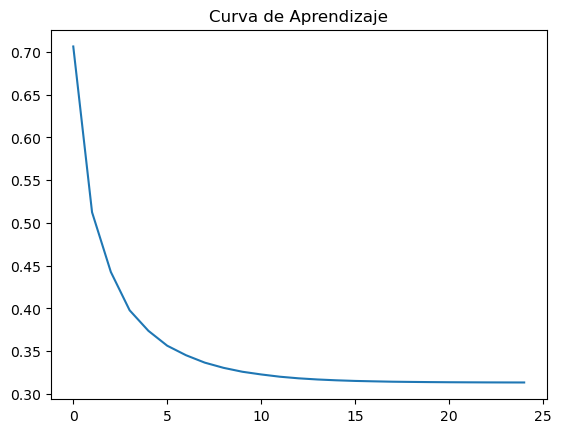

In [21]:
optimizer = tr.optim.Adam(model_wrapper.parameters(), lr=1e-3)

print("\n--- Iniciando Overfitting Test ---")
losses = []

for step in range(25): # 25 hardcoded
    optimizer.zero_grad()
    
    # 1. Samplear tiempo aleatorio
    t = tr.randint(0, TIMESTEPS, (BATCH_SIZE,)).long()
    
    # 2. Generar muestra ruidosa
    xt_noisy = model_wrapper.q_sample(x0_oh, t)
    
    # 3. Predecir logits
    logits_pred = model_wrapper.predict_start(xt_noisy, t, condition)
    
    # 4. Calcular Loss (CrossEntropy contra los índices originales x0_idx)
    # x0_idx es [1, 4, 4], logits es [1, 2, 4, 4] -> PyTorch lo maneja bien
    loss = F.cross_entropy(logits_pred, x0_idx)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if step % 20 == 0:
        print(f"Paso {step}, Loss: {loss.item():.6f}")

# Graficar la caída de la loss
plt.plot(losses)
plt.title("Curva de Aprendizaje")
plt.show()


--- Iniciando Overfitting Test (Híbrido: Simple + VLB) ---


Paso 0 | Total: 0.042111 | Simple: 0.824698 | VLB: 0.042111
Paso 1 | Total: 0.027296 | Simple: 0.402083 | VLB: 0.027296
Paso 2 | Total: 0.051681 | Simple: 0.261049 | VLB: 0.051681
Paso 3 | Total: 0.009979 | Simple: 0.211679 | VLB: 0.009979
Paso 4 | Total: 0.000175 | Simple: 0.179253 | VLB: 0.000175
Paso 5 | Total: 0.002004 | Simple: 0.164295 | VLB: 0.002004
Paso 6 | Total: 0.006539 | Simple: 0.146633 | VLB: 0.006539
Paso 7 | Total: 0.000618 | Simple: 0.126503 | VLB: 0.000618
Paso 8 | Total: 0.000364 | Simple: 0.112686 | VLB: 0.000364
Paso 9 | Total: 0.009062 | Simple: 0.097411 | VLB: 0.009062
Paso 10 | Total: 0.000888 | Simple: 0.083262 | VLB: 0.000888
Paso 11 | Total: 0.001121 | Simple: 0.070775 | VLB: 0.001121
Paso 12 | Total: 0.000046 | Simple: 0.063300 | VLB: 0.000046
Paso 13 | Total: 0.000588 | Simple: 0.057280 | VLB: 0.000588
Paso 14 | Total: 0.000389 | Simple: 0.052220 | VLB: 0.000389
Paso 15 | Total: 0.002026 | Simple: 0.046387 | VLB: 0.002026
Paso 16 | Total: 0.000029 | Simple

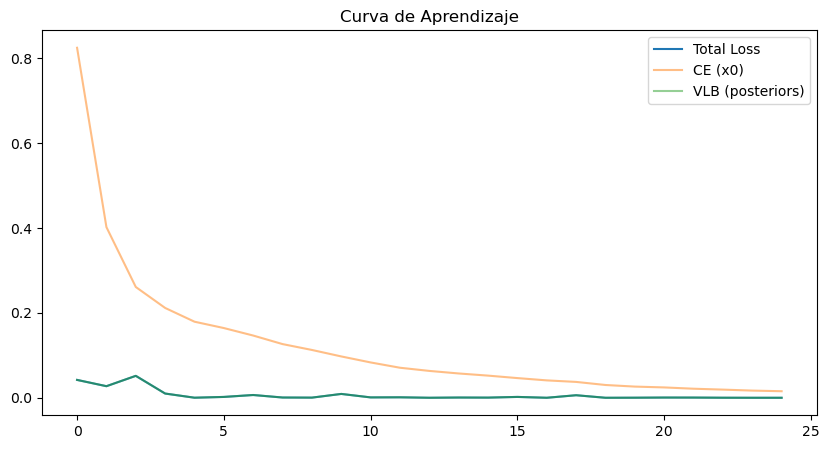

In [ ]:
model_wrapper = DiffusionModel(
    num_classes=NUM_CLASSES, 
    time_steps=TIMESTEPS, 
    model=SimpleUNet, 
    in_channels=18, 
    base_dim=32 # UNet pequeña para este test
)

# Factor de peso para la loss variacional
LAMBDA_VLB = 1 

optimizer = tr.optim.Adam(model_wrapper.parameters(), lr=1e-3)

print("\n--- Iniciando Overfitting Test (Híbrido: Simple + VLB) ---")
losses = []
losses_simple = [] # Para graficar por separado si quieres  
vlb_losses = []    # Para graficar por separado si quieres

for step in range(25): 
    optimizer.zero_grad()
    
    # 1. Samplear tiempo aleatorio
    t = tr.randint(0, TIMESTEPS, (BATCH_SIZE,)).long()
    
    # 2. Generar muestra ruidosa
    xt_noisy = model_wrapper.q_sample(x0_oh, t)
    
    # --- LOSS 1: SIMPLE (Reconstrucción) ---
    #  return_logits=True para usar CrossEntropy
    logits_pred = model_wrapper.predict_start(xt_noisy, t, condition, return_logits=True)
    loss_simple = F.cross_entropy(logits_pred, x0_idx)
    
    # --- LOSS 2: VLB (NLL ) ---
    # Calcula la KL Divergence entre la posterior real y la predicha
    loss_vlb = model_wrapper.compute_vlb(x0_oh, xt_noisy, t, condition)
    
    loss = loss_vlb
    # --- LOSS TOTAL ---
    # loss = loss_simple + (LAMBDA_VLB * loss_vlb)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    losses_simple.append(loss_simple.item())
    vlb_losses.append(loss_vlb.item())
    
    if step % 1 == 0:
        print(f"Paso {step} | Total: {loss.item():.6f} | Simple: {loss_simple.item():.6f} | VLB: {loss_vlb.item():.6f}")

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Total Loss")
plt.plot(losses_simple, label="CE (x0)", alpha=0.5)
plt.plot(vlb_losses, label="VLB (posteriors)", alpha=0.5)
plt.legend()
plt.title("Curva de Aprendizaje")
plt.show()

5. Validación Final: Sampling

que genere la matriz I desde ruido puro.

In [23]:
print("\n--- Generando muestra desde ruido puro ---")
# Usamos el loop p_sample_loop
generated_sample = model_wrapper._sample(condition)

print("Original:")
print(x0_idx[0])
print("Generado:")
print(generated_sample[0])

# Verificación automática
if tr.equal(x0_idx[0], generated_sample[0]):
    print("ÉXITO: reconstrucción perfecta.")
else:
    print("La reconstrucción no es perfecta (revisar).")


--- Generando muestra desde ruido puro ---
Original:
tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])
Generado:
tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])
ÉXITO: reconstrucción perfecta.



--- TEST FINAL: Generación Post-Entrenamiento ---


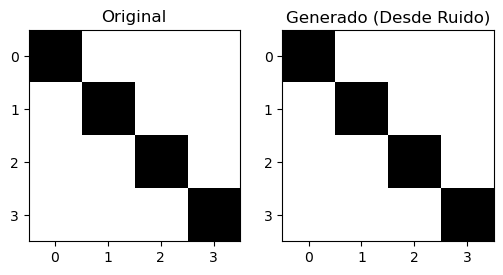

Ground Truth (Diagonal):
tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

Generado por el modelo:
tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])


In [24]:
print("\n--- TEST FINAL: Generación Post-Entrenamiento ---")
generated = model_wrapper._sample(condition)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x0_idx[0].cpu(), cmap="Greys")
plt.subplot(1,2,2)
plt.title("Generado (Desde Ruido)")
plt.imshow(generated[0].cpu(), cmap="Greys")
plt.show()


print("Ground Truth (Diagonal):")
print(x0_idx[0])

print("\nGenerado por el modelo:")
print(generated[0])


In [25]:
def test_posterior_sum_to_one(model, x0_oh, t_step):
    """Verifica que la suma de probabilidades de la posterior sea 1."""
    # Creamos un xt dummy (no importa cual sea para este test matemático)
    xt_dummy = tr.randint(0, model.num_classes, (1, 4, 4))
    
    # Creamos un x0 dummy en probabilidad (simulando output de la red)
    x0_pred_dummy = tr.rand_like(x0_oh) 
    x0_pred_dummy = x0_pred_dummy / x0_pred_dummy.sum(dim=1, keepdim=True) # Normalizar
    
    # Calculamos posterior
    t_tensor = tr.tensor([t_step])
    posterior = model.q_posterior( x0_pred_dummy,xt_dummy, t_tensor)
    
    # Sumamos sobre la dimensión de clases (dim 1)
    sums = posterior.sum(dim=1)
    print(sums.shape)
    print(sums)
    # Verificamos
    is_valid = tr.allclose(sums, tr.ones_like(sums), atol=1e-5)
    
    print(f"Test Posterior t={t_step}: {'✅ Pasa' if is_valid else '❌ Falla'}")
    if not is_valid:
        print(f"   Max deviation: {tr.max(tr.abs(sums - 1.0))}")

# Ejecutar en pasos intermedios
test_posterior_sum_to_one(model_wrapper, x0_oh, 10)
test_posterior_sum_to_one(model_wrapper, x0_oh, 25)

torch.Size([1, 4, 4])
tensor([[[1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000]]])
Test Posterior t=10: ✅ Pasa
torch.Size([1, 4, 4])
tensor([[[1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000]]])
Test Posterior t=25: ✅ Pasa


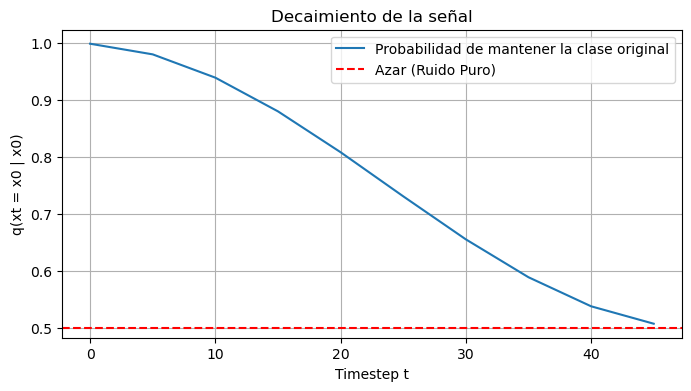

In [26]:
def plot_signal_decay(model, x0_oh):
    """Grafica la probabilidad asignada a la clase correcta a través del tiempo."""
    timesteps = tr.arange(0, model.time_steps, step=5) # Muestrear cada 10 pasos
    probs_correct_class = []
    
    # Tomamos un pixel donde sabemos que hay un 1 (Clase Contacto)
    # x0_idx tiene unos en la diagonal. Usamos pixel (0,0)
    # x0_oh[0, 1, 0, 0] debería ser 1.0.
    
    for t in timesteps:
        t_tensor = tr.tensor([t])
        probs = model.q_pred(x0_oh, t_tensor)
        
        # Extraemos la prob del canal 1 en el pixel (0,0)
        # Suponiendo que en (0,0) x0 era clase 1.
        p_correct = probs[0, 1, 0, 0].item()
        probs_correct_class.append(p_correct)
        
    plt.figure(figsize=(8, 4))
    plt.plot(timesteps, probs_correct_class, label="Probabilidad de mantener la clase original")
    plt.axhline(y=1.0/model.num_classes, color='r', linestyle='--', label="Azar (Ruido Puro)")
    plt.xlabel("Timestep t")
    plt.ylabel("q(xt = x0 | x0)")
    plt.title("Decaimiento de la señal")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_signal_decay(model_wrapper, x0_oh)